<a href="https://www.kaggle.com/code/abhinavbhuyan/classification-xgboost-with-bayesian-optimization?scriptVersionId=93389201" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction
We perform binary classification on breast cancer dataset using XGBoost, augmented with hyperparameter optimization using Bayesian sampling.
- Load breast cancer dataset
    - Cleaning & EDA
    - Visualization
- Feature engineering
    - Prepare feature and targets and drop non-informative features
    - Split into train and test sets
- Bayesian optimization
    - Define XGBoost classifier model, search space, evaluation metric & cross-validaion strategy (stratified k-fold)
    - Run optimization for n iterations to find best parameters
- Model training and analysis
    - Configure XGBoost model with best parameters and fit to train set
    - Draw tree graphs
    - Plot feature importance
- Evaluation
    - Use fitted model to make predictions on test set
    - Compute mean accuracy
    - Draw confusion matrix

### Imports

In [1]:
# Core
import numpy as np
import pandas as pd
from time import time
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ML
import xgboost as xgb
from xgboost import XGBClassifier, DMatrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from skopt import BayesSearchCV
from skopt.space import Real, Integer

## Data and preprocessing

In [2]:
df = pd.read_csv('../input/breast-cancer-dataset/breast-cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [4]:
# Prep features and target
X = df.drop(['id', 'diagnosis'], axis=1).values
y = df.diagnosis.values

In [5]:
# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Bayesian optimization

In [6]:
# XGBoost classifier base model
xgb_clf = xgb.XGBClassifier(
    n_jobs = 1,
    booster = 'gbtree',
    objective = 'binary:logistic',
    eval_metric = 'auc', 
    tree_method='gpu_hist', 
    enable_categorical = True, 
    early_stopping_rounds = 5,
    verbosity = 0
)

In [7]:
# Define search space
search_spaces = {
     'learning_rate': Real(0.01, 1.0, 'log-uniform'),
     'max_depth': Integer(2, 20),
     'min-child-weight': Integer(1, 5),
     'reg_lambda': Real(1e-9, 100., 'log-uniform'),
     'reg_alpha': Real(1e-9, 100., 'log-uniform'),
     'gamma': Real(1e-9, 0.5, 'log-uniform'),  
     'n_estimators': Integer(10, 5000)
}

In [8]:
# Create Bayesian CV for HP optimization
bayes_cv = BayesSearchCV(
                    estimator = xgb_clf,                                    
                    search_spaces = search_spaces,                      
                    scoring = 'roc_auc',                                  
                    cv = StratifiedKFold(n_splits=5, shuffle=True),                                   
                    n_iter = 20,                                      
                    n_points = 5,                                       
                    n_jobs = 1,                                         
                    iid = False,                                        
                    refit=False,
                    verbose = 1,
                    random_state=42
)                               

In [9]:
# Run bayesian CV
%time bayes_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: user 9min 44s, sys: 8.54 s, total: 9min 53s
Wall time: 9min 53s


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster='gbtree',
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=5,
                                      enable_categorical=True,
                                      eval_metric='auc', gamma=None,
                                      gpu_id=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_ra...
                             'max_depth': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'min-child-weight': Integer(low=1, high=5, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(lo

In [10]:
# Show best params
print('Best parameters:')
pprint.pprint(bayes_cv.best_params_)
print("Best score = %.3f after %d runs" % (bayes_cv.best_score_, bayes_cv.n_iter))

Best parameters:
OrderedDict([('gamma', 1e-09),
             ('learning_rate', 0.31961211247936544),
             ('max_depth', 20),
             ('min-child-weight', 3),
             ('n_estimators', 5000),
             ('reg_alpha', 0.8042967191291566),
             ('reg_lambda', 100.0)])
Best score = 0.993 after 20 runs


## Model training

In [11]:
# Create XGBoost classifier with best params
xgb_clf_tuned = xgb.XGBClassifier(
        n_jobs = 5,
        objective = 'binary:logistic',
        eval_metric = 'auc', 
        tree_method = 'gpu_hist', 
        booster = 'gbtree',
        enable_categorical = True, 
        early_stopping_rounds = 5,
        **bayes_cv.best_params_
)

In [12]:
# Fit to train data
xgb_clf_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=5,
              enable_categorical=True, eval_metric='auc', gamma=1e-09, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.31961211247936544, max_delta_step=0, max_depth=20,
              min-child-weight=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=5,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.8042967191291566, reg_lambda=100.0,
              scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
              validate_parameters=1, ...)

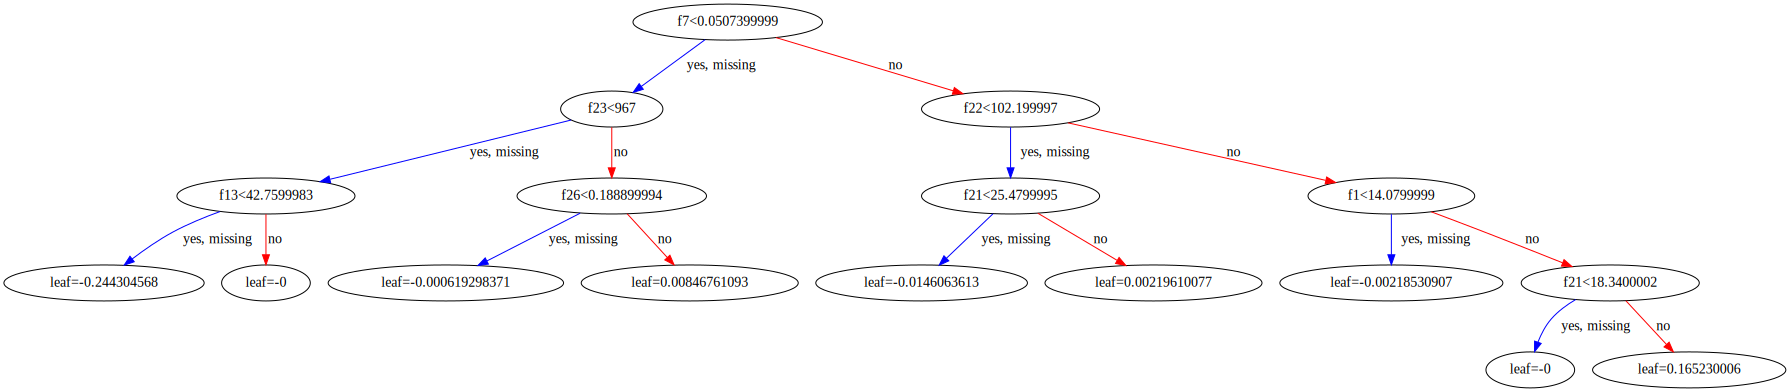

In [13]:
# Visualize decision tree
xgb.to_graphviz(xgb_clf_tuned, num_tree=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

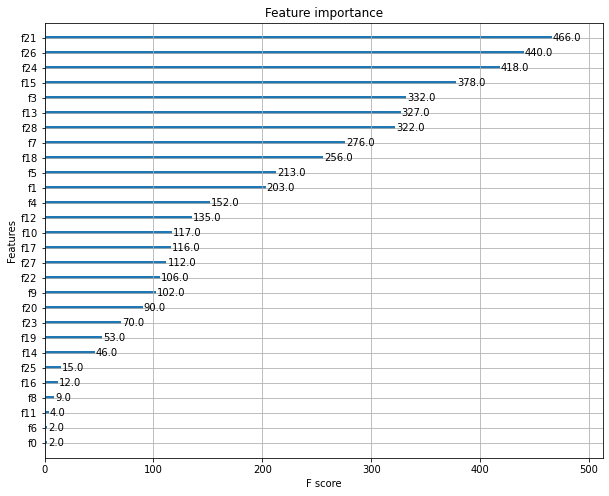

In [14]:
# Feature importance plot
fig, ax = plt.subplots(figsize = (10, 8))
xgb.plot_importance(xgb_clf_tuned, ax=ax)

## Prediction and evaluation

In [15]:
# Predict on test set using fitted model
y_pred = xgb_clf_tuned.predict(X_test)

In [16]:
# Mean accuracy
accuracy_score(y_test, y_pred)

0.9649122807017544

<AxesSubplot:>

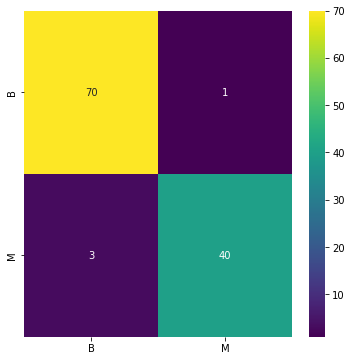

In [17]:
# Confusion matrix
conf = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(conf, index = ['B', 'M'], columns = ['B', 'M'])
plt.figure(figsize = (6, 6))
sns.heatmap(df_conf, annot=True, cmap='viridis')